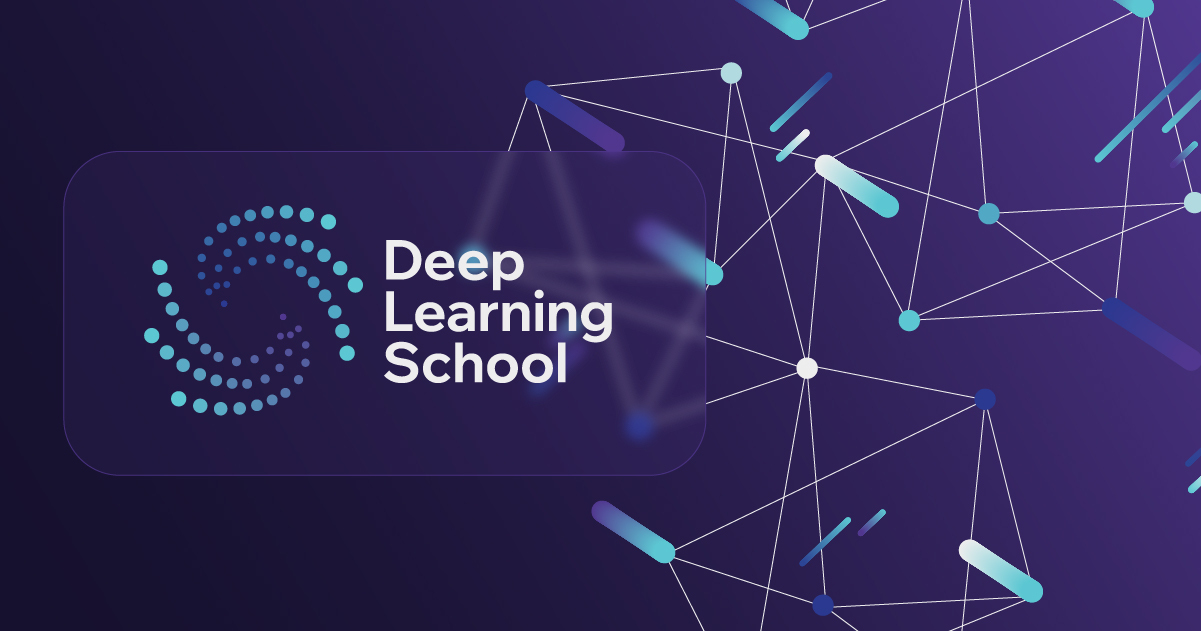


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [54]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [55]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

# !gdown 10O65UguenTnVVnN0on6C9Hgkd0jhL5SM

In [56]:
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [57]:
!ls train

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [58]:
!ls

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [59]:
!ls train

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [60]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 14 21:26:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti   WDDM  |   00000000:03:00.0  On |                  N/A |
|  0%   38C    P8             18W /  280W |    3829MiB /  11264MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [61]:
import pickle
import numpy as np
from skimage import io

# from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from tqdm.auto import tqdm

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [62]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [63]:
!python --version

Python 3.11.9


In [64]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.8.0.dev20250327+cu128
torchvision version: 0.22.0.dev20250329+cu128
tqdm version: 4.67.1
matplotlib version: 3.10.1
seaborn version: 0.13.2
Pillow version: 11.1.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [65]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [66]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [67]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [68]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/simpsons_dataset/')
TEST_DIR = Path('./testset/testset')

In [69]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [70]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [71]:
val_dataset = SimpsonsDataset(val_files, mode='val')

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

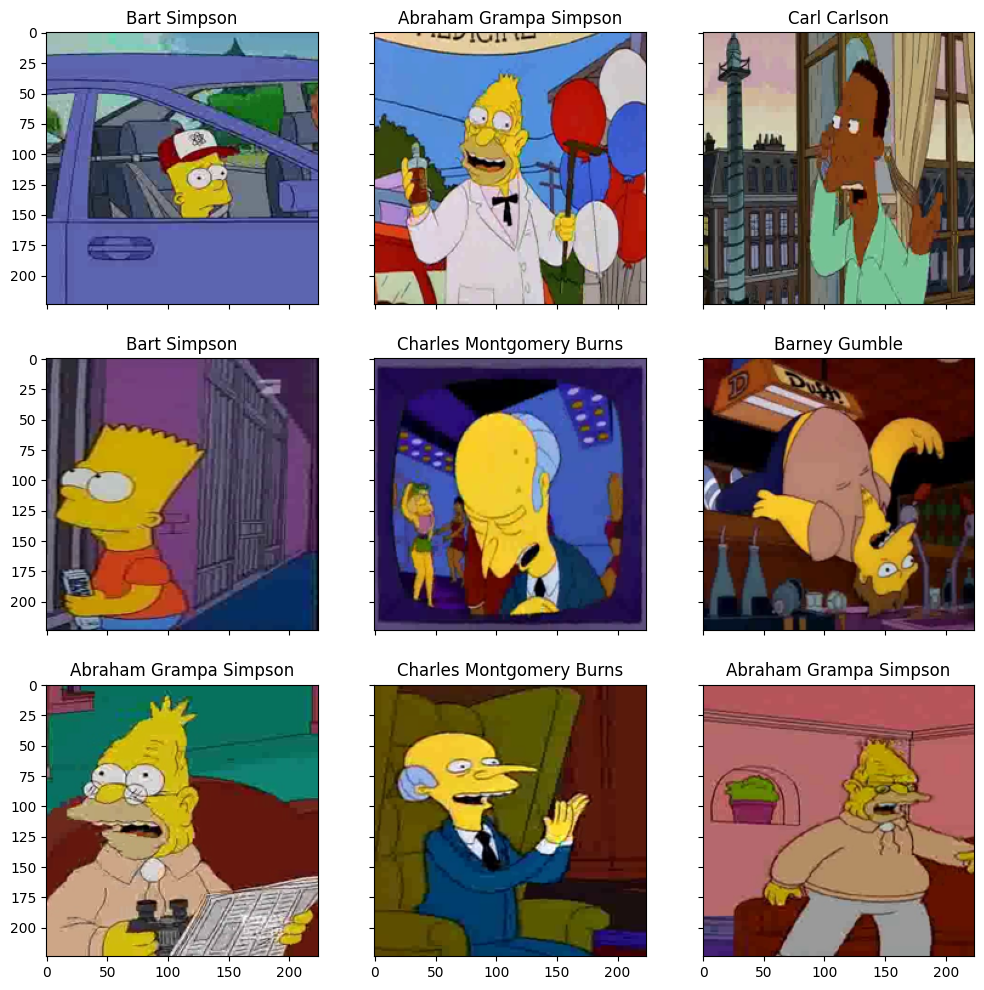

In [72]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [73]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

#### Функция обучения:

In [74]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [75]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [76]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [77]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [78]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [79]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [83]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

NameError: name 'history' is not defined

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: name 'loss' is not defined

<Figure size 1500x900 with 0 Axes>

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [84]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


NameError: name 'label_encoder' is not defined

In [ ]:
import pandas as pd
my_submit = pd.read_csv("./sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

In [ ]:
# !kaggle competitions submit -c journey-springfield -f .\hw5\simple_cnn_baseline.csv -m simple_baseline

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [85]:
# Увеличим количество эпох и добавим аугментации
epochs = 15
batch_size = 32

In [86]:
# Улучшенные аугментации для тренировочных данных
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(RESCALE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [87]:
# Для валидации оставляем только нормализацию
val_transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [88]:
# Модифицируем класс Dataset для использования аугментаций
# Класс датасета
class ImprovedSimpsonsDataset(SimpsonsDataset):
    def __init__(self, files, mode):
        self.files = sorted(files)
        self.mode = mode
        self.label_encoder = LabelEncoder()
        
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as f:
                pickle.dump(self.label_encoder, f)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        image = transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(image)
        
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
        image = transform(image)
        
        if self.mode == 'test':
            return image
        else:
            label = self.label_encoder.transform([self.labels[idx]])
            return image, label.item()

In [89]:
# Пересоздаем датасеты с аугментациями
train_dataset = ImprovedSimpsonsDataset(train_files, mode='train')
val_dataset = ImprovedSimpsonsDataset(val_files, mode='val')

In [90]:
# Используем предобученную модель ResNet18
import torchvision.models as models

class TransferModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, n_classes)
        
    def forward(self, x):
        return self.base_model(x)

In [91]:
# Инициализация модели
model = TransferModel(n_classes).to(DEVICE)

c:\Users\Mishele Dolmin\CODE\DLS\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mishele Dolmin\CODE\DLS\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
# Добавляем оптимизатор и scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [93]:
# Функция обучения
def train_model(model, train_dataset, val_dataset, optimizer, scheduler, batch_size, epochs):
    from tqdm import tqdm
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=0)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        with tqdm(train_loader, unit="batch", 
                 desc=f"Epoch {epoch+1}/{epochs} [Train]", 
                 bar_format='{l_bar}{bar:20}{r_bar}') as pbar:
            for inputs, labels in pbar:
                try:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    train_loss += loss.item() * inputs.size(0)
                    correct_train += (preds == labels).sum().item()
                    total_train += inputs.size(0)
                
                    pbar.set_postfix({
                        'loss': f"{train_loss/total_train:.4f}",
                        'acc': f"{correct_train/total_train:.4f}"
                    })
                except Exception as e:
                    print(f"\nError during training: {str(e)}")
                    raise

        train_loss = train_loss / len(train_dataset)
        train_acc = correct_train / len(train_dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        
        with torch.no_grad(), tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs} [Val]") as pbar:
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                correct_val += (preds == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': val_loss/len(val_dataset),
                    'acc': correct_val/len(val_dataset)
                })

        val_loss = val_loss / len(val_dataset)
        val_acc = correct_val / len(val_dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        # Update visualization
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Loss Evolution')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title('Accuracy Evolution')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')
        print(f'Best Val Acc: {best_acc:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

    return history

In [ ]:
# history = train_model(
#         model=model,
#         train_dataset=train_dataset,
#         val_dataset=val_dataset,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         batch_size=batch_size,
#         epochs=10
#     )

In [94]:
def visualize_training_history(history):
    """Визуализация истории обучения с готовыми данными"""
    plt.figure(figsize=(18, 6))
    
    # График потерь
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o', linestyle='-', color='blue')
    plt.plot(history['val_loss'], label='Val Loss', marker='o', linestyle='-', color='orange')
    plt.title('Training and Validation Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # График точности
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(history['val_acc'], label='Val Accuracy', marker='o', linestyle='-', color='orange')
    plt.title('Training and Validation Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # График learning rate
    # plt.subplot(1, 3, 3)
    # plt.plot(history['lr'], label='Learning Rate', marker='o', linestyle='-', color='green')
    # plt.title('Learning Rate Schedule', fontsize=12)
    # plt.xlabel('Epoch', fontsize=10)
    # plt.ylabel('Learning Rate', fontsize=10)
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Вывод финальных метрик
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
    # print(f"Final Learning Rate: {history['lr'][-1]:.2e}")

# Пример использования:
# history = {
#     'train_loss': [...], 'train_acc': [...],
#     'val_loss': [...], 'val_acc': [...],
#     'lr': [...]
# }
visualize_training_history(history)

NameError: name 'history' is not defined

In [ ]:
# Загрузка лучшей модели для предсказаний
model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
# Создание сабмита
test_dataset = ImprovedSimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]
pd.DataFrame({'Id': test_filenames, 'Expected': preds}).to_csv('improved_submission.csv', index=False)

print("Сабмит готов!")

In [ ]:
!dir

 ��� � ���ன�⢥ C �� ����� ��⪨.
 ��਩�� ����� ⮬�: 7A0B-1B4B

 ����ন��� ����� c:\Users\Mishele Dolmin\CODE\DLS\hw5

13.04.2025  22:11    <DIR>          .
13.04.2025  22:11    <DIR>          ..
13.04.2025  21:41        44�873�931 best_model.pth
23.04.2020  21:00           598�494 characters_illustration.png
13.04.2025  14:04            27�298 improved_submission.csv
13.04.2025  22:10            26�374 improved_submission1.csv
13.04.2025  00:29       546�224�286 journey-springfield.zip
13.04.2025  21:02             4�272 label_encoder.pkl
23.04.2020  21:00            23�686 sample_submission.csv
13.04.2025  13:12            27�809 simple_cnn_baseline.csv
13.04.2025  10:18    <DIR>          testset
13.04.2025  10:18    <DIR>          train
13.04.2025  21:05         1�527�428 �����_2.ipynb
13.04.2025  21:05         1�527�428 �����_�������__hw_5_simpsons_classification_ipynb_.ipynb
              10 䠩���    594�861�006 ����
               4 �����  79�490�093�056 ���� ᢮�����


In [ ]:
# !kaggle competitions submit -c journey-springfield -f improved_submission.csv -m improved_01

400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/competitions/submissions/submit/journey-springfield



  0%|          | 0.00/25.8k [00:00<?, ?B/s]
100%|██████████| 25.8k/25.8k [00:01<00:00, 25.0kB/s]
